[[  0.   -15.    -8.66]
 [  0.    15.    -8.66]
 [  0.     0.    17.32]]
    local_cell_index  local_branch_index  local_comp_index  length  radius  \
0                  0                   0                 0    10.0     1.0   
1                  0                   0                 1    10.0     1.0   
2                  0                   0                 2    10.0     1.0   
3                  0                   0                 3    10.0     1.0   
4                  0                   0                 4    10.0     1.0   
5                  0                   0                 5    10.0     1.0   
6                  0                   0                 6    10.0     1.0   
7                  0                   0                 7    10.0     1.0   
8                  0                   0                 8    10.0     1.0   
9                  0                   0                 9    10.0     1.0   
10                 0                   0                10    10.0   

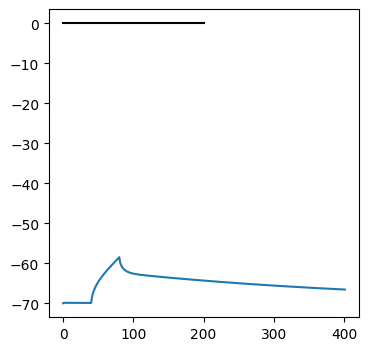

In [5]:
"""
Training Loop
"""
import os
import jax
import jax.numpy as jnp
import numpy as np
import jaxley as jx
from jaxley.solver_gate import solve_gate_exponential, save_exp
from jaxley.channels import Channel
import matplotlib.pyplot as plt
from typing import Dict, Optional

# import jaxley.optimize.transforms as jt
# from jax import random
# import tensorflow_probability.substrates.jax as tfp
# import optax
# from jax import jit, vmap, value_and_grad
# import jax.lax as lax

def _vtrap(x, y):
    return x / (save_exp(x / y) - 1.0)

class HH(Channel):
    """Hodgkin-Huxley channel."""

    def __init__(self, name: Optional[str] = None):
        self.current_is_in_mA_per_cm2 = True

        super().__init__(name)
        prefix = self._name
        self.channel_params = {
            f"{prefix}_gNa": 0.12,
            f"{prefix}_gK": 0.036,
            f"{prefix}_gLeak": 0.0003,
            f"{prefix}_eNa": 60.0,
            f"{prefix}_eK": -77.0,
            f"{prefix}_eLeak": -54.3,
        }
        self.channel_states = {
            f"{prefix}_m": 0.2,
            f"{prefix}_h": 0.2,
            f"{prefix}_n": 0.2,
        }
        self.current_name = f"i_HH"

    def update_states(
        self,
        states: Dict[str, jnp.ndarray],
        dt,
        v,
        params: Dict[str, jnp.ndarray],
    ):
        """Return updated HH channel state."""
        prefix = self._name
        m, h, n = states[f"{prefix}_m"], states[f"{prefix}_h"], states[f"{prefix}_n"]
        new_m = solve_gate_exponential(m, dt, *self.m_gate(v))
        new_h = solve_gate_exponential(h, dt, *self.h_gate(v))
        new_n = solve_gate_exponential(n, dt, *self.n_gate(v))
        return {f"{prefix}_m": new_m, f"{prefix}_h": new_h, f"{prefix}_n": new_n}

    def compute_current(
        self, states: Dict[str, jnp.ndarray], v, params: Dict[str, jnp.ndarray]
    ):
        """Return current through HH channels."""
        prefix = self._name
        m, h, n = states[f"{prefix}_m"], states[f"{prefix}_h"], states[f"{prefix}_n"]

        gNa = params[f"{prefix}_gNa"] * (m**3) * h  # S/cm^2
        gK = params[f"{prefix}_gK"] * n**4  # S/cm^2
        gLeak = params[f"{prefix}_gLeak"]  # S/cm^2

        return (
            gNa * (v - params[f"{prefix}_eNa"])
            + gK * (v - params[f"{prefix}_eK"])
            + gLeak * (v - params[f"{prefix}_eLeak"])
        )

    def init_state(self, states, v, params, delta_t):
        """Initialize the state such at fixed point of gate dynamics."""
        prefix = self._name
        alpha_m, beta_m = self.m_gate(v)
        alpha_h, beta_h = self.h_gate(v)
        alpha_n, beta_n = self.n_gate(v)
        return {
            f"{prefix}_m": alpha_m / (alpha_m + beta_m),
            f"{prefix}_h": alpha_h / (alpha_h + beta_h),
            f"{prefix}_n": alpha_n / (alpha_n + beta_n),
        }

    @staticmethod
    def m_gate(v):
        alpha = 2.725 * _vtrap(-(v + 35), 10)
        beta = 90.83 * save_exp(-(v + 60) / 20)
        return alpha, beta

    @staticmethod
    def h_gate(v):
        alpha = 1.817 * save_exp(-(v + 52) / 20)
        beta = 27.25 / (save_exp(-(v + 22) / 10) + 1)
        return alpha, beta

    @staticmethod
    def n_gate(v):
        alpha = 0.09575 * _vtrap(-(v + 37), 10)
        beta = 1.915 * save_exp(-(v + 47) / 80)
        return alpha, beta

SEED = 0
GPU = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU)

NUM_EPOCHS = 400
SIM_TIME_SAMPLES = 700
TIME_STEP = 2e-3 #ms
ELEC_SPACING = 30.0
DUMP_PERIOD = 20
TOTAL_LENGTH = 20.0
SEGMENT_LENGTH = 1.0
assert TOTAL_LENGTH % SEGMENT_LENGTH == 0, "TOTAL_LENGTH must be divisible by SEGMENT_LENGTH"
NUM_COMPARTMENTS = int(TOTAL_LENGTH/SEGMENT_LENGTH)
VOLTAGE_CLAMP_SEGMENT = 50
VOLTAGE_CLAMP_VALUE = 0.0
STOP_CRITERION = 0.05
PERCENTILE_SAMPLE_AND_CLIP = 0.85
SAVE_NAME = f'seed_{SEED}'
np.random.seed(SEED)
ELECTRODE_CONFIGURATION = 'triangle'
elec_coords = None

if ELECTRODE_CONFIGURATION == 'triangle':
    #place electrodes at equilateral traiangle in x=0 plane, center at (0,0,0), spaced ELEC_SPACING apart
    elec_coords = np.array([[0, 0, 0], [0, 1, 0], [0, 0.5, 0.866]])
    elec_coords = elec_coords - np.mean(elec_coords, axis=0)
    elec_coords = ELEC_SPACING*elec_coords
    elec_coords = jnp.array(elec_coords, dtype=jnp.float32)
    elec_coords = jax.device_put(elec_coords) # Move to default accelerator (GPU if available)




class SimpleCell:
    def __init__(self, cell):
        self.cell = cell

    def transform_params(self):
        pass

    def compute_membrane_currents(self):
        pass

    def compute_eap(self):
        pass

# Build the cell.
comp = jx.Compartment()
branch = jx.Branch([comp]*NUM_COMPARTMENTS)
cell = jx.Cell([branch], parents=[-1])

# Insert channels.
cell.insert(Leak())
cell.insert(Na())
cell.insert(K())

print(cell.nodes)

# Change parameters.
cell.set("axial_resistivity", 200.0)

# Visualize the morphology.
cell.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell.vis(ax=ax)

# Stimulate.
current = jx.step_current(i_delay=1.0, i_dur=1.0, i_amp=0.1, delta_t=0.025, t_max=10.0)
cell.branch(0).loc(0.0).stimulate(current)

# Record.
cell.branch(0).loc(0.0).record("v")

# Simulate and plot.
v = jx.integrate(cell, delta_t=0.025)
plt.plot(v.T)




In [ ]:
class JaxleyTrainer:
    def __init__(self, cell, data, epochs, dt = 0.05, tmax = 5 ):
        # load through data
        self.cell = cell
        self.data_point = data
        
        self.i_delay = 1.0  # ms
        self.i_dur = 0.15  # ms
        self.i_amp = 3.9  # nA
        self.electrode = generate_electrode_map(519)
        self.ncomp = self.cell.shape[1]
        self.params = self.setup_params()
        for i, param_dict in enumerate(self.params):
            for param_name, param_values in param_dict.items():
                if param_name in ['radius', 'length']:
                    print(f"Branch {i}, {param_name}: shape={param_values.shape}")
                    print(f"  min={jnp.min(param_values):.10f}")
                    print(f"  max={jnp.max(param_values):.10f}")
                    print(f"  mean={jnp.mean(param_values):.10f}")
                    print(f"  any_nan={jnp.any(jnp.isnan(param_values))}")
                    print(f"  any_inf={jnp.any(jnp.isinf(param_values))}")
        transforms = [{k: self.create_transforms(k) for k in param} for param in self.params]

        self.tf = jt.ParamTransform(transforms)
        self.lengths = self.cell.nodes["length"] ### fix
        self.lengths.to_numpy()
        self.lengths = jnp.array(self.lengths)
        self.N_ELECTRODES = LITKE_519_ARRAY_GRID.shape[0]
        self.grid = jnp.array(LITKE_519_ARRAY_GRID)
        self.delta_t = 0.05 # ms
        self.t_max = 5
        
        self.num_epochs = epochs
        self.current_compartment_positions = fh.compute_comp_xyz(self.cell)
        self.compartment_surface_areas = fh.get_surface_areas(self.cell) * 10E-8  
        self.opt_params = self.tf.inverse(self.params)

        hold_steps = 15000  # Number of steps to hold the learning rate constant
        decay_steps = 30000  # Total training steps (or however many steps you want the cosine decay to complete)

        # 1. Constant learning rate for first 5000 steps
        constant = optax.constant_schedule(value=1e-1)

        # 2. Cosine decay from 1e-1 to 1e-5
        cosine = optax.cosine_decay_schedule(
            init_value=1e-1,
            decay_steps=decay_steps - hold_steps,
            alpha=1e-5 / 1e-1  # final_lr / init_lr
        )

        # Combine the schedules
        schedule = optax.join_schedules(
            schedules=[constant, cosine],
            boundaries=[hold_steps]
        )
        self.optimizer = optax.chain(
            optax.clip_by_global_norm(1.0), 
            optax.adam(learning_rate=schedule)
        )
        self.opt_state = self.optimizer.init(self.opt_params)
        
        self.jitted_grad = jit(value_and_grad(self.loss, argnums=0))

    def compute_comp_xyz(self, transformed_params):
        '''
        Returns (Ncomps, 3) array of xyz positions of all the compartments
        '''
        
        # 
        all_x = []
        all_y = []
        all_z = []
    
        for param_dict in transformed_params:
            if 'x' in param_dict:
                all_x.append(param_dict['x'])
            if 'y' in param_dict:
                all_y.append(param_dict['y'])
            if 'z' in param_dict:
                all_z.append(param_dict['z'])
        xs = jnp.concatenate(all_x) 
        ys = jnp.concatenate(all_y) 
        zs = jnp.concatenate(all_z) 
        
        comp_xyz = jnp.stack([xs, ys, zs], axis=1)
        return comp_xyz
    
    def final_compute_xyz(self, transformed_params):
        all_x = []
        all_y = []
        all_z = []
    
        for param_dict in transformed_params:
            if 'x' in param_dict:
                all_x.append(param_dict['x'])
            if 'y' in param_dict:
                all_y.append(param_dict['y'])
            if 'z' in param_dict:
                all_z.append(param_dict['z'])
        xs = jnp.concatenate(all_x) 
        ys = jnp.concatenate(all_y) 
        zs = jnp.concatenate(all_z) 
        return xs, ys, zs
    def get_surface_areas(self, transformed_params):
        '''
        Returns (Ncomps,) array of the surface areas in um2 of all the compartments
        JAX-compatible version
        '''
        all_radii = []
        all_lengths = []
        
        for param_dict in transformed_params:
            if 'radius' in param_dict:
                all_radii.append(param_dict['radius'])
            if 'length' in param_dict:
                all_lengths.append(param_dict['length'])

        radii = jnp.concatenate(all_radii) 
        lengths = jnp.concatenate(all_lengths) 

        
        surf_areas = 2 * jnp.pi * radii * lengths
        return surf_areas
    
    def create_transforms(self, name: str) -> jt.Transform:
        """
        Creates robust parameter transformations using SigmoidTransform
        for physical constraints.
        """
        # --- For morphology coordinates ---
        if name in ['x', 'y', 'z']:
            return jt.AffineTransform(1.0, 0.0)  # No constraints
        if name in ['radius', 'length']:
            return jt.ChainTransform([jt.SoftplusTransform(0), jt.AffineTransform(10, 0)])
        
        return jt.AffineTransform(1.0, 0.0)
        
        
    def setup_params(self):
        self.cell.delete_trainables()
        self.cell.comp("all").make_trainable("x")
        self.cell.comp("all").make_trainable("y")
        self.cell.comp("all").make_trainable("z")
        # self.cell.comp("all").make_trainable("radius")
        # self.cell.comp("all").make_trainable("length")
        # self.cell.comp("all").make_trainable("HH_eNa")
        # self.cell.comp("all").make_trainable("HH_eK")
        # self.cell.comp("all").make_trainable('axial_resistivity')
        # self.cell.comp("all").make_trainable('HH_gNa')
        # self.cell.comp("all").make_trainable('HH_gLeak')
        # self.cell.comp("all").make_trainable('gCa')
        # self.cell.comp("all").make_trainable('HH_gK')
        # self.cell.comp("all").make_trainable('gKCa')

        return self.cell.get_parameters()


    def simulate(self, params):
        """
        
        """
        
        
        
        delta_t = 0.05 # ms
        t_max = 5
        time_vec = np.arange(0, t_max+2*delta_t, delta_t)

        i_delay = 1.0 
        i_dur = 0.5
        i_amp = 15
        current = jx.step_current(i_delay=i_delay, i_dur=i_dur, i_amp=i_amp, delta_t=delta_t, t_max=t_max)

        self.cell.delete_stimuli()
        data_stimuli = None
        data_stimuli = self.cell.branch(0).comp(0).data_stimulate(current)

        self.cell.delete_recordings()
        self.cell.record("v")
        self.cell.record("i_HH")
        self.cell.record("i_Ca")
        self.cell.record("i_KCa")

        sim_outputs = jx.integrate(self.cell, params = params, data_stimuli=data_stimuli).reshape(4, self.ncomp, -1)
        return sim_outputs
    
    def gen_ei(self, outputs, transformed_params):
        """
        Generate extracellular potential from simulation outputs
        """
        tfd = tfp.distributions
        seed = random.PRNGKey(0)

        time_vec = np.arange(0, self.t_max+2*self.delta_t, self.delta_t)
        current_compartment_positions = self.compute_comp_xyz(transformed_params)
        # compartment_surface_areas = self.get_surface_areas(transformed_params) * 10E-8  # Calculate surface areas in cm^2
        
        current_distance = fh.distance(LITKE_519_ARRAY_GRID, current_compartment_positions) * 10E-4 
        
        sim_v_extra = fh.compute_eap(outputs, current_distance, self.compartment_surface_areas) \
             + tfd.Normal(0, 0.0001).sample((self.N_ELECTRODES, len(time_vec)), seed=seed)
        sim_EI = self.with_ttl(sim_v_extra).T
        return sim_EI
    
    def with_ttl(self, raw_data):
        shape_array = jnp.array(raw_data.shape)
        has_512 = jnp.any(shape_array == 512)
        has_519 = jnp.any(shape_array == 519)
  
        critical_axis_512 = jnp.where(shape_array == 512, size=1, fill_value=-1)[0]
        critical_axis_519 = jnp.where(shape_array == 519, size=1, fill_value=-1)[0]
        
        critical_axis = jnp.where(has_512, critical_axis_512, critical_axis_519)

        append_data_shape = list(raw_data.shape)
        
        for i, dim_size in enumerate(raw_data.shape):
            if dim_size == 512 or dim_size == 519:
                critical_axis = i
                break
        
        append_data_shape[critical_axis] = 1
        append_data = jnp.zeros(append_data_shape)
        
        return jnp.concatenate((append_data, raw_data), axis=critical_axis)

    def predict(self, params):
        outputs = self.simulate(params)
        predicted_ei = self.gen_ei(outputs, params)
        return predicted_ei

    def loss(self, opt_params, true_ei):
        """
        Computes a loss that is robust to temporal shifts by using a
        differentiable soft-alignment mechanism.
        """
        transformed_params = self.tf.forward(opt_params)
        predicted_ei = self.predict(transformed_params)

        true_len = true_ei.shape[0]
        pred_len = predicted_ei.shape[0]
        n_electrodes = true_ei.shape[1]
        max_offset = pred_len - true_len

        def compute_loss_at_offset(offset):
            pred_window = lax.dynamic_slice(
                predicted_ei,
                start_indices=[offset, 0],
                slice_sizes=[true_len, n_electrodes]
            )

            epsilon = 1e-6
            pred_norm = (pred_window - jnp.mean(pred_window)) / (jnp.std(pred_window) + epsilon)
            true_norm = (true_ei - jnp.mean(true_ei)) / (jnp.std(true_ei) + epsilon)

            mse = jnp.mean((pred_norm - true_norm)**2)
            return mse

        offsets = jnp.arange(max_offset + 1)
        all_mse_losses = vmap(compute_loss_at_offset)(offsets)

        
        temperature = 1.0
        weights = jax.nn.softmax(-all_mse_losses * temperature)

        final_loss = jnp.sum(weights * all_mse_losses)


        return final_loss

    
    def train(self):
        epoch_losses = []
        for epoch in range(self.num_epochs):
            epoch_loss = 0.0
            
            loss_val, gradient = self.jitted_grad(self.opt_params, self.data_point)
            flat_grads, _ = jax.tree_util.tree_flatten(gradient)
            if jnp.isnan(loss_val):
                break
            if flat_grads: 
                grad_norm = jnp.linalg.norm(jnp.concatenate([g.flatten() for g in flat_grads]))
                print(f"Epoch {epoch}, Loss {loss_val}, Grad Norm: {grad_norm}")
            else:
                print(f"Epoch {epoch}, Loss {loss_val}, No gradients found.")
            updates, self.opt_state = self.optimizer.update(gradient, self.opt_state)
            self.opt_params = optax.apply_updates(self.opt_params, updates)
            epoch_loss += loss_val
        
            print(f"epoch {epoch}, loss {epoch_loss}")
            epoch_losses.append(epoch_loss)
        final_params = self.tf.forward(self.opt_params)
        # xs,ys,zs = self.final_compute_xyz(final_params) 
        # self.cell.comp(all).move_to(xs,ys,zs, update_nodes=True)




        sim_ei = self.predict(final_params)
        return final_params, sim_ei, epoch_losses